neural_network

# Custom Feedforward Network

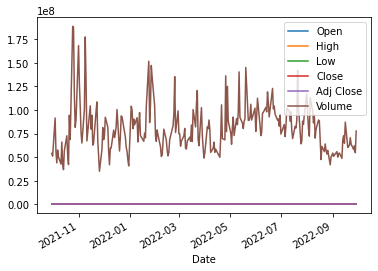

In [2]:
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot

from pandas.plotting import autocorrelation_plot

def parser(x):
	return datetime.strptime(x,'%Y-%m-%d')
 
series = read_csv('data/stock_yfinance_data_tsla.csv', header=0, parse_dates=[0], index_col=0)
series = series.drop(['Stock Name', 'Adj Close'], axis=1)
series.plot()
pyplot.show()

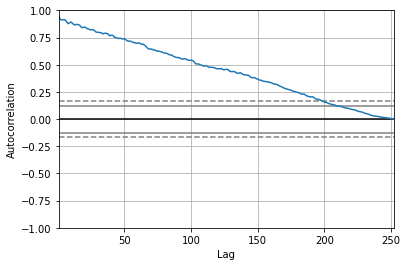

In [3]:
autocorrelation_plot(series)
pyplot.show()

Epoch 1/100
7/7 [==============================] - 0s 917us/step - loss: 1.7325
Epoch 2/100
7/7 [==============================] - 0s 834us/step - loss: 1.4156
Epoch 3/100
7/7 [==============================] - 0s 833us/step - loss: 1.1083
Epoch 4/100
7/7 [==============================] - 0s 833us/step - loss: 0.7698
Epoch 5/100
7/7 [==============================] - 0s 835us/step - loss: 0.6445
Epoch 6/100
7/7 [==============================] - 0s 749us/step - loss: 0.4665
Epoch 7/100
7/7 [==============================] - 0s 783us/step - loss: 0.3498
Epoch 8/100
7/7 [==============================] - 0s 879us/step - loss: 0.3155
Epoch 9/100
7/7 [==============================] - 0s 835us/step - loss: 0.2053
Epoch 10/100
7/7 [==============================] - 0s 752us/step - loss: 0.1504
Epoch 11/100
7/7 [==============================] - 0s 833us/step - loss: 0.1349
Epoch 12/100
7/7 [==============================] - 0s 764us/step - loss: 0.1283
Epoch 13/100
7/7 [===================

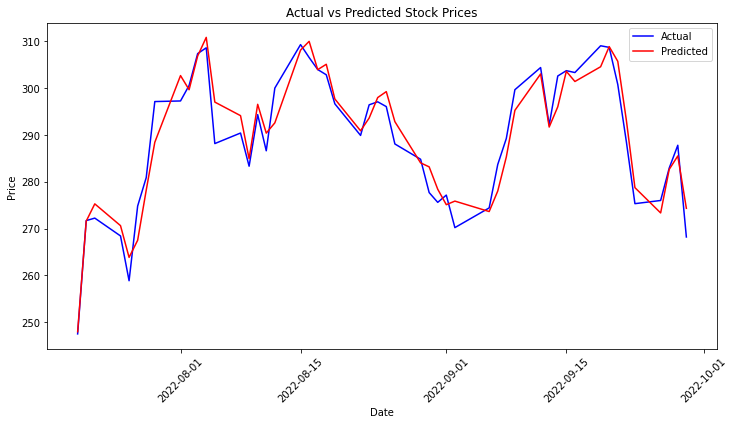

Mean Squared Error: 14.937690148244187


In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the target variable (y) and the features (X)
y = series['Close']
X = series.drop('Close', axis=1)

# Split into train and test (80% train, 20% test)
train_size = int(len(series) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale the features (X) using StandardScaler
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target variable (y) using StandardScaler
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Reshape for compatibility
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Define the model
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train_scaled.shape[1]))  # Fewer units
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32)

# Predict on the test data (predictions are scaled)
forecast_scaled = model.predict(X_test_scaled)

# Reshape forecast to 1D
forecast_scaled = forecast_scaled.reshape(-1)

# Inverse transform the forecast to get original scale values
forecast = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1))

# Convert y_test to numpy for consistency with forecast
y_test_dates = y_test.index.to_numpy()

# Plot the actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test_dates, y_test.values, label='Actual', color='blue')  # Actual values
plt.plot(y_test_dates, forecast, label='Predicted', color='red')  # Predicted values
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for readability
plt.show()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, forecast)
print(f'Mean Squared Error: {mse}')


# VAE

Epoch 1/100
4/4 [==============================] - 0s 2ms/step - loss: 1.8516
Epoch 2/100
4/4 [==============================] - 0s 1ms/step - loss: 1.5401
Epoch 3/100
4/4 [==============================] - 0s 2ms/step - loss: 0.9353
Epoch 4/100
4/4 [==============================] - 0s 2ms/step - loss: 0.7590
Epoch 5/100
4/4 [==============================] - 0s 2ms/step - loss: 0.7425
Epoch 6/100
4/4 [==============================] - 0s 2ms/step - loss: 0.7623
Epoch 7/100
4/4 [==============================] - 0s 1ms/step - loss: 0.7207
Epoch 8/100
4/4 [==============================] - 0s 2ms/step - loss: 0.7129
Epoch 9/100
4/4 [==============================] - 0s 1ms/step - loss: 0.6548
Epoch 10/100
4/4 [==============================] - 0s 2ms/step - loss: 0.6943
Epoch 11/100
4/4 [==============================] - 0s 2ms/step - loss: 0.6569
Epoch 12/100
4/4 [==============================] - 0s 2ms/step - loss: 0.5880
Epoch 13/100
4/4 [==============================] - 0s 1ms/st

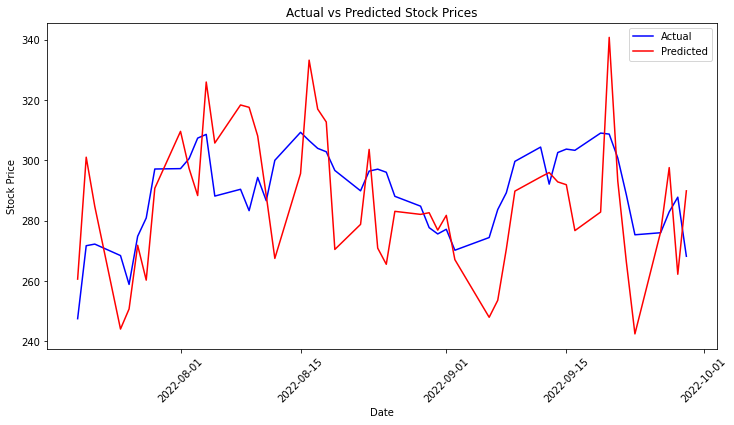

In [51]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import backend as K
import numpy as np

# Define the target variable (y) and the features (X)
y = series['Close']
X = series.drop('Close', axis=1)

# Split into train and test (80% train, 20% test)
train_size = int(len(series) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale the features (X) using StandardScaler
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target variable (y) using StandardScaler
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Reshape for compatibility
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Define input shape
input_shape = X_train_scaled.shape[1]  # Number of features

# Define the encoder architecture
inputs = Input(shape=(input_shape,))
encoded = Dense(128, activation='relu')(inputs)
z_mean = Dense(64)(encoded)  # Mean of the latent space
z_log_var = Dense(64)(encoded)  # Log-variance of the latent space

# Reparameterization trick: sample z from the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(64,))([z_mean, z_log_var])

# Define the decoder architecture for predicting the "Close" price
decoder_hid = Dense(128, activation='relu')
decoder_out = Dense(1, activation='linear')  # Single output for the "Close" price

h_decoded = decoder_hid(z)
x_decoded_mean = decoder_out(h_decoded)

# Define the VAE model
vae = Model(inputs, x_decoded_mean)

# Define the VAE loss
# MSE loss for the reconstruction error, as you're predicting stock prices
mse_loss = K.mean(K.square(inputs - x_decoded_mean), axis=-1)
# KL divergence
kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(mse_loss + kl_loss)

# Compile the VAE model
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Train the VAE model
vae.fit(X_train_scaled, epochs=100, batch_size=64)

# Get predictions from the VAE model
predicted_scaled = vae.predict(X_test_scaled)

# Rescale the predictions and the true values back to the original scale
predicted = scaler_y.inverse_transform(predicted_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

y_test_dates = y_test.index.to_numpy()
mse = mean_squared_error(y_test_original, predicted)
print(mse)
# Plot the actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test_dates, y_test_original, label='Actual', color='blue')  # Actual values
plt.plot(y_test_dates, predicted, label='Predicted', color='red')  # Predicted values
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for readability
plt.show()


# LSTM

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [24]:
data = pd.read_csv('data/stock_yfinance_data_tsla.csv', header=0, index_col=0, parse_dates=True)
data = data[['Open', 'High', 'Low', 'Close']]

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

In [26]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Extract sequence of length `seq_length`
        X_sequence = data.iloc[i:i+seq_length].values.tolist()
        X.append(X_sequence)
        
        # Target is the 'Close' price after the sequence
        y.append(data.iloc[i + seq_length]['Close'])
    return X, y

In [33]:
from sklearn.model_selection import train_test_split

# Hyperparameters
seq_length = 60  # The number of time steps (days) to look back
X, y = create_sequences(scaled_data, seq_length)

# Convert lists to TensorFlow-friendly format
X = tf.convert_to_tensor(X, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

# Split into training and testing sets
train_size = int(X.shape[0] * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [34]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

NotImplementedError: Cannot convert a symbolic Tensor (lstm_3/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverse scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(data.index[:len(y_train_actual)], y_train_actual, label='Train Actual')
plt.plot(data.index[len(y_train_actual):len(y_train_actual) + len(y_test_actual)], y_test_actual, label='Test Actual')
plt.plot(data.index[:len(train_predict)], train_predict, label='Train Predict')
plt.plot(data.index[len(train_predict):len(train_predict) + len(test_predict)], test_predict, label='Test Predict')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()